In [1]:
from pathlib import Path
from python.optimization import TopOpt
from python.postprocessor import Post2D, Post3D

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("python/")
res_dir    = Path("results/")
mod_dir    = Path("models/")
TopOpt.set_paths(ANSYS_path, script_dir, res_dir, mod_dir)

# Test case
- Half MBB 168 mm x 80 mm x 8 mm
- Mesh:
    - **2D**: 42 x 20 elements (4 mm element)
    - **3D**: 42 x 20 x 2 elements (4 mm element)
- 1 kN downward force


- Cellulose and 0.5 bamboo
- volfrac = 0.3
- r_rho = 6
- r_theta = 20
- theta0 = 50°
- 100 iterations

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex   = Efiber*Vfiber + Ematrix*Vmatrix
Ey   = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy  = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nuxy = vfiber*Vfiber + vmatrix*Vmatrix
rho  = rhofiber*Vfiber + rhomatrix*Vmatrix

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [3]:
solver1 = TopOpt(inputfile='mbb2d', dim='2D', jobname='2d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=6, r_theta=20, theta0=50, max_iter=100)
solver1.optim()

print()
print('Total elapsed time     {:7.2f}s'.format(solver1.time))
print('FEA time               {:7.2f}s'.format(solver1.fea_time))
print('Derivation time        {:7.2f}s'.format(solver1.deriv_time))
print('Variable updating time {:7.2f}s'.format(solver1.mma.update_time))

Iteration   0...  compliance = 43829.0890
Iteration   1...  compliance = 12520.1363
Iteration   2...  compliance =  8654.0043
Iteration   3...  compliance =  6160.9185
Iteration   4...  compliance =  5584.1602
Iteration   5...  compliance =  5021.7834
Iteration   6...  compliance =  4522.6258
Iteration   7...  compliance =  4485.1752
Iteration   8...  compliance =  4355.7900
Iteration   9...  compliance =  4359.8737
Iteration  10...  compliance =  4571.7704
Iteration  11...  compliance =  4347.3975
Iteration  12...  compliance =  4519.2777
Iteration  13...  compliance =  4372.9767
Iteration  14...  compliance =  4368.9764
Iteration  15...  compliance =  4319.6156
Iteration  16...  compliance =  4183.0505
Iteration  17...  compliance =  4202.1682
Iteration  18...  compliance =  4035.1240
Iteration  19...  compliance =  4012.6734
Iteration  20...  compliance =  3880.7545
Iteration  21...  compliance =  3878.7340
Iteration  22...  compliance =  3842.1302
Iteration  23...  compliance =  37

CO2 footprint: 2685.73 kgCO2


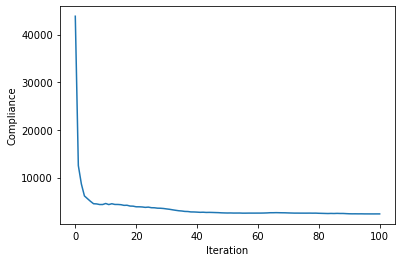

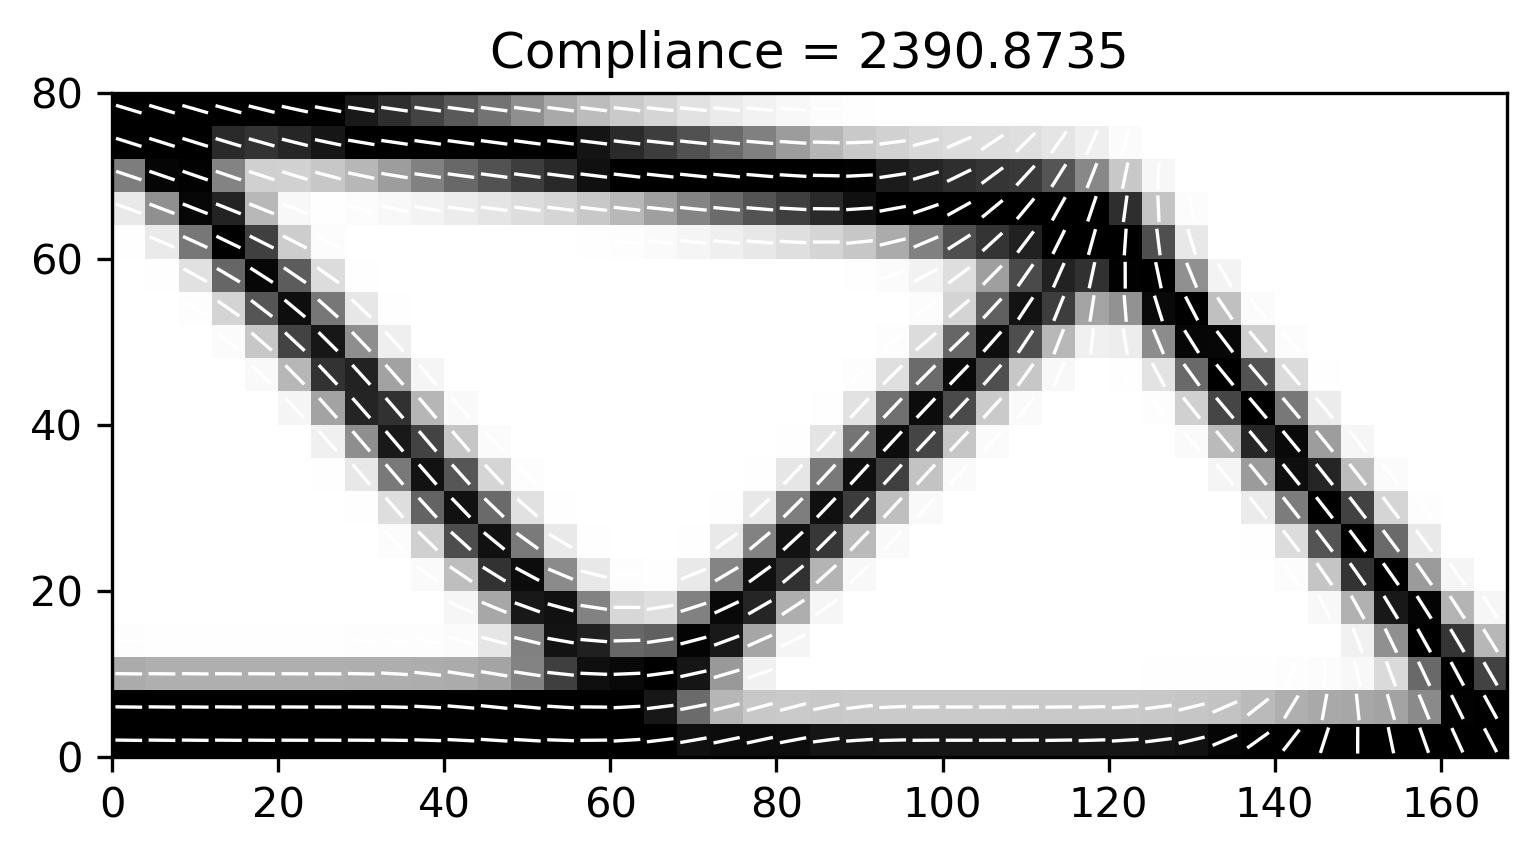

In [4]:
post1 = Post2D(solver1)
post1.plot_convergence()
post1.plot()

print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post1.CO2_footprint(rho, CO2mat, CO2veh)))

In [5]:
solver2 = TopOpt(inputfile='mbb3d', dim='3D', jobname='3d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=6, r_theta=20, theta0=50, max_iter=100)
solver2.optim()

print()
print('Total elapsed time:     {:7.2f}s'.format(solver2.time))
print('FEA time:               {:7.2f}s'.format(solver2.fea_time))
print('Derivation time:        {:7.2f}s'.format(solver2.deriv_time))
print('Variable updating time: {:7.2f}s'.format(solver2.mma.update_time))

Iteration   0...  compliance = 44636.4407
Iteration   1...  compliance = 12806.2350
Iteration   2...  compliance =  8601.7511
Iteration   3...  compliance =  6056.5959
Iteration   4...  compliance =  5665.0216
Iteration   5...  compliance =  4629.8982
Iteration   6...  compliance =  4798.5622
Iteration   7...  compliance =  4478.9654
Iteration   8...  compliance =  4455.8827
Iteration   9...  compliance =  4476.4024
Iteration  10...  compliance =  4433.8539
Iteration  11...  compliance =  4552.5268
Iteration  12...  compliance =  4416.1362
Iteration  13...  compliance =  4460.0333
Iteration  14...  compliance =  4361.6286
Iteration  15...  compliance =  4357.5871
Iteration  16...  compliance =  4255.5260
Iteration  17...  compliance =  4321.4936
Iteration  18...  compliance =  4086.1780
Iteration  19...  compliance =  4096.0835
Iteration  20...  compliance =  3937.7738
Iteration  21...  compliance =  3866.3728
Iteration  22...  compliance =  3868.3395
Iteration  23...  compliance =  37

CO2 footprint: 2586.44 kgCO2


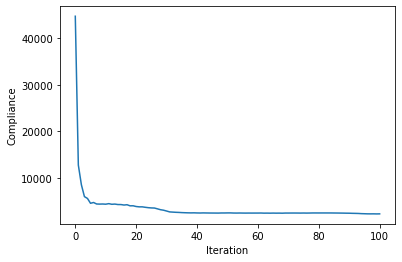

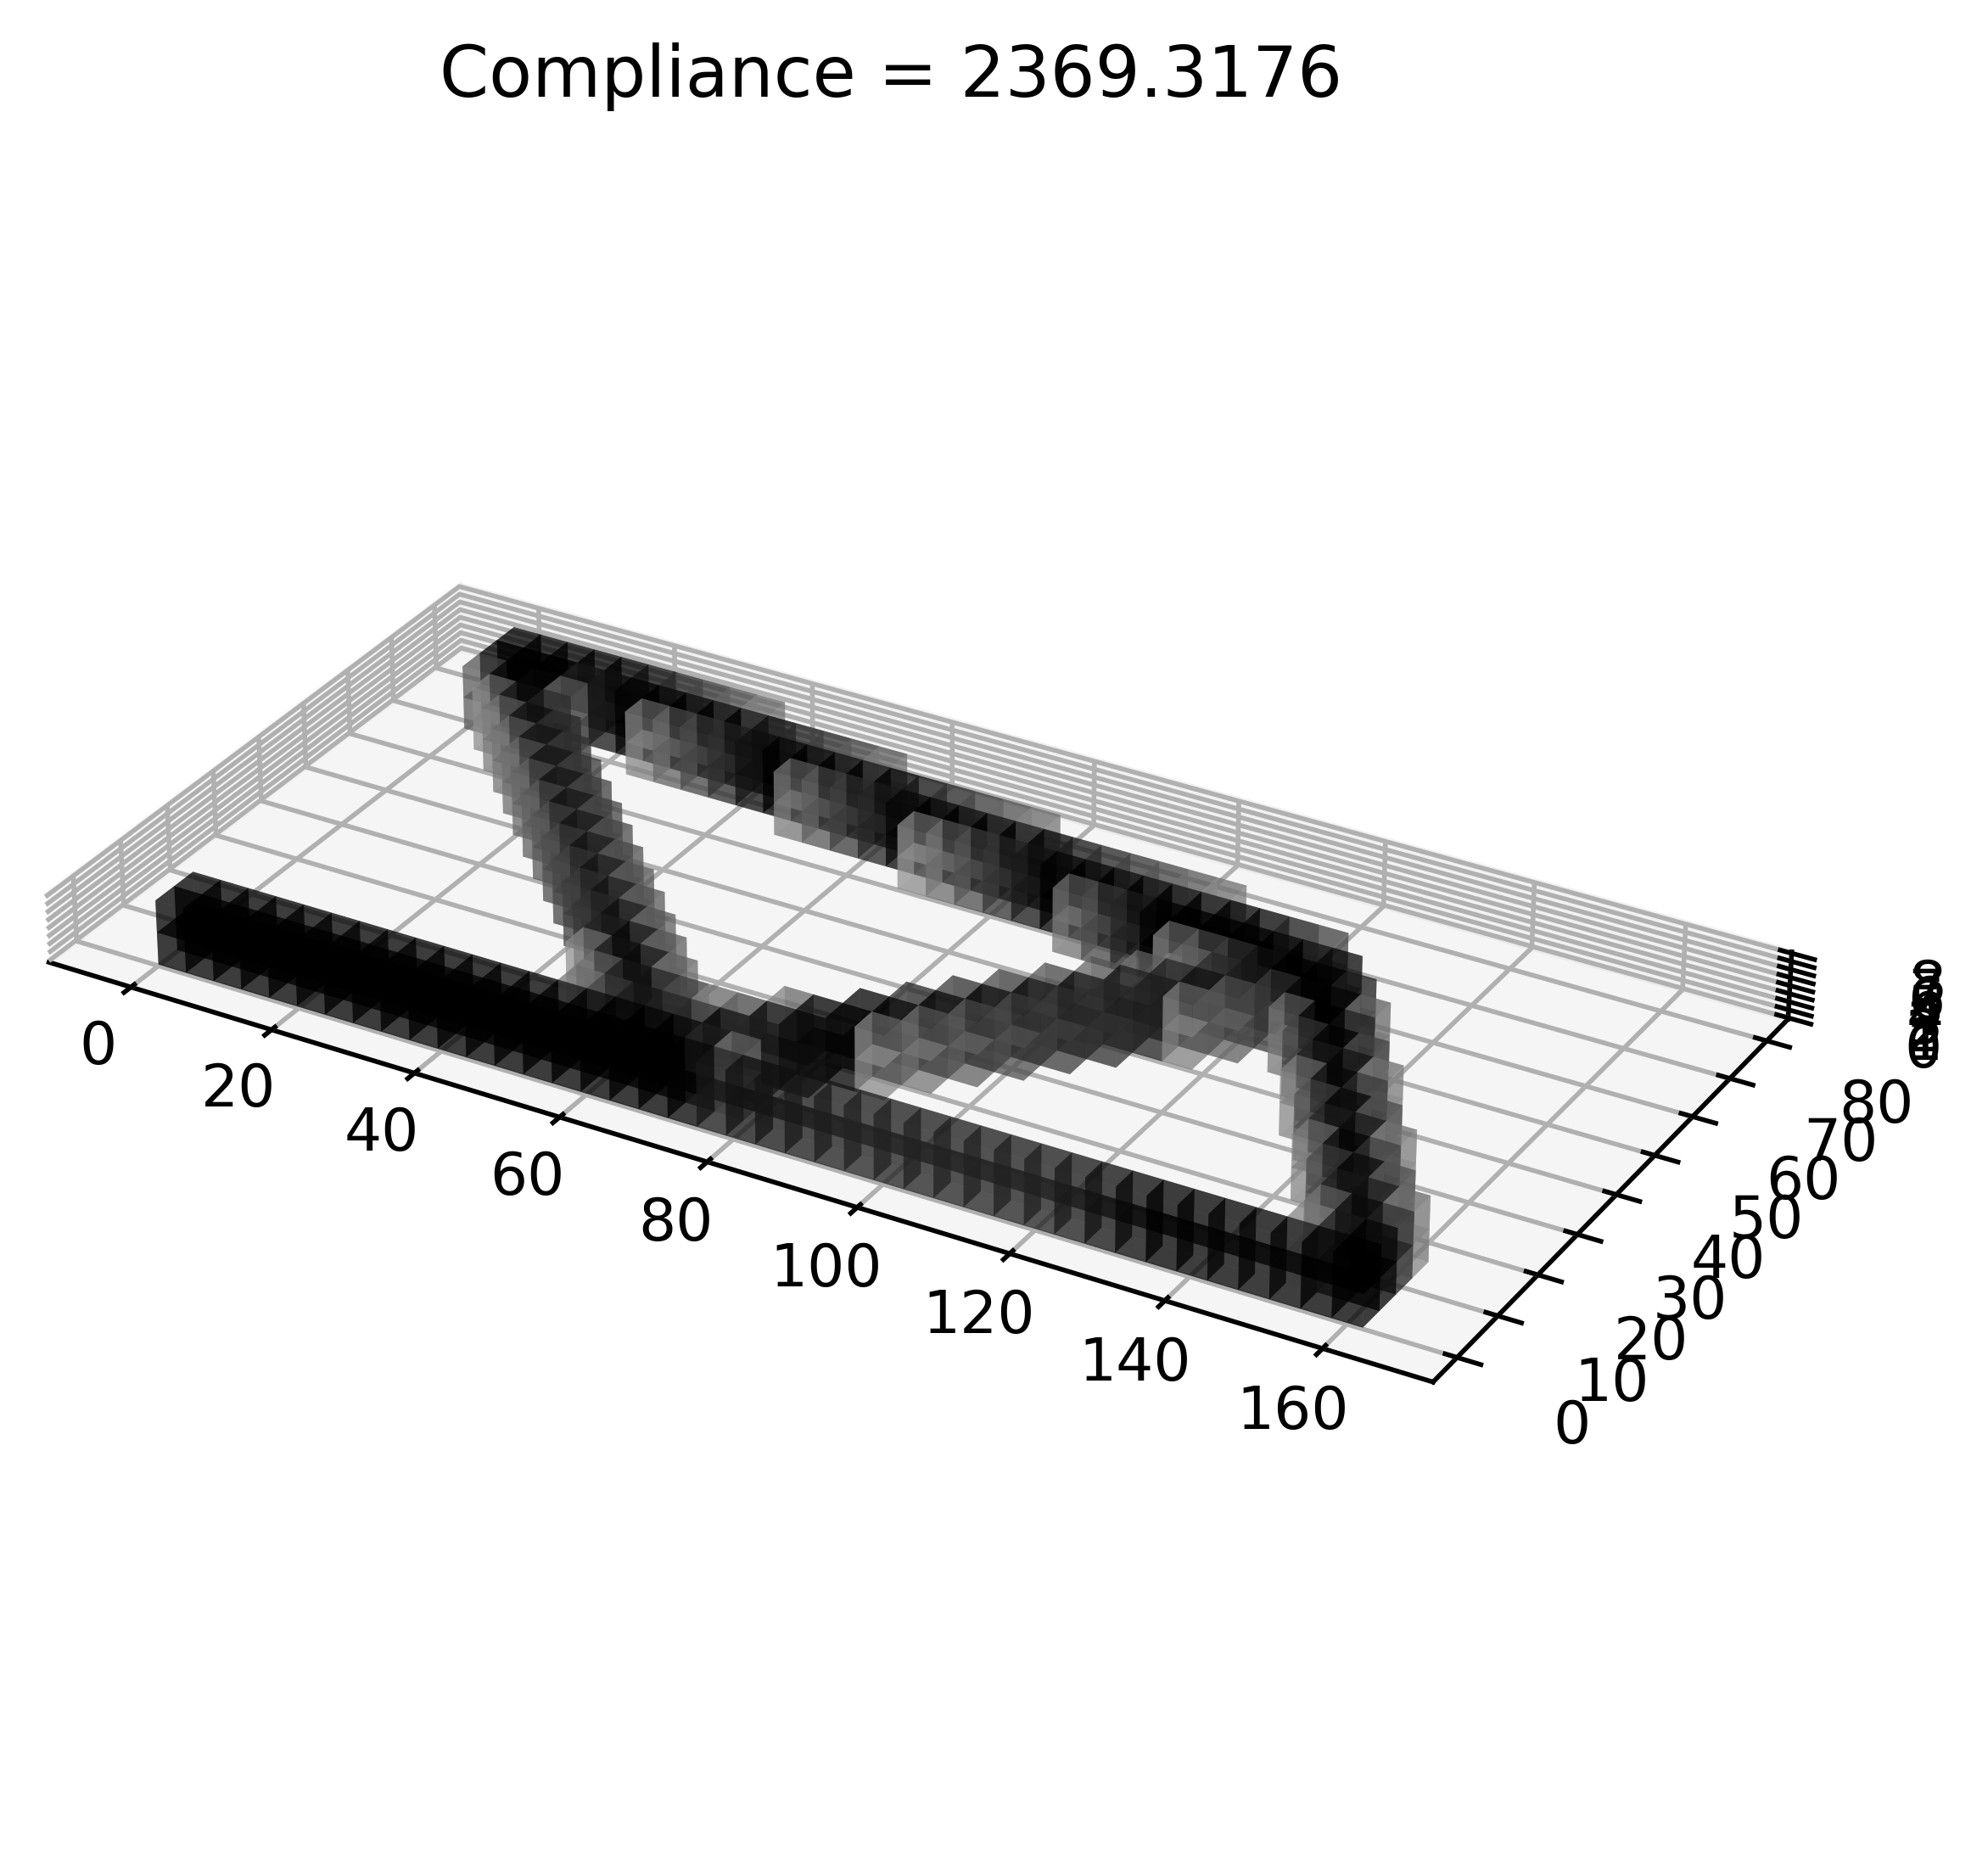

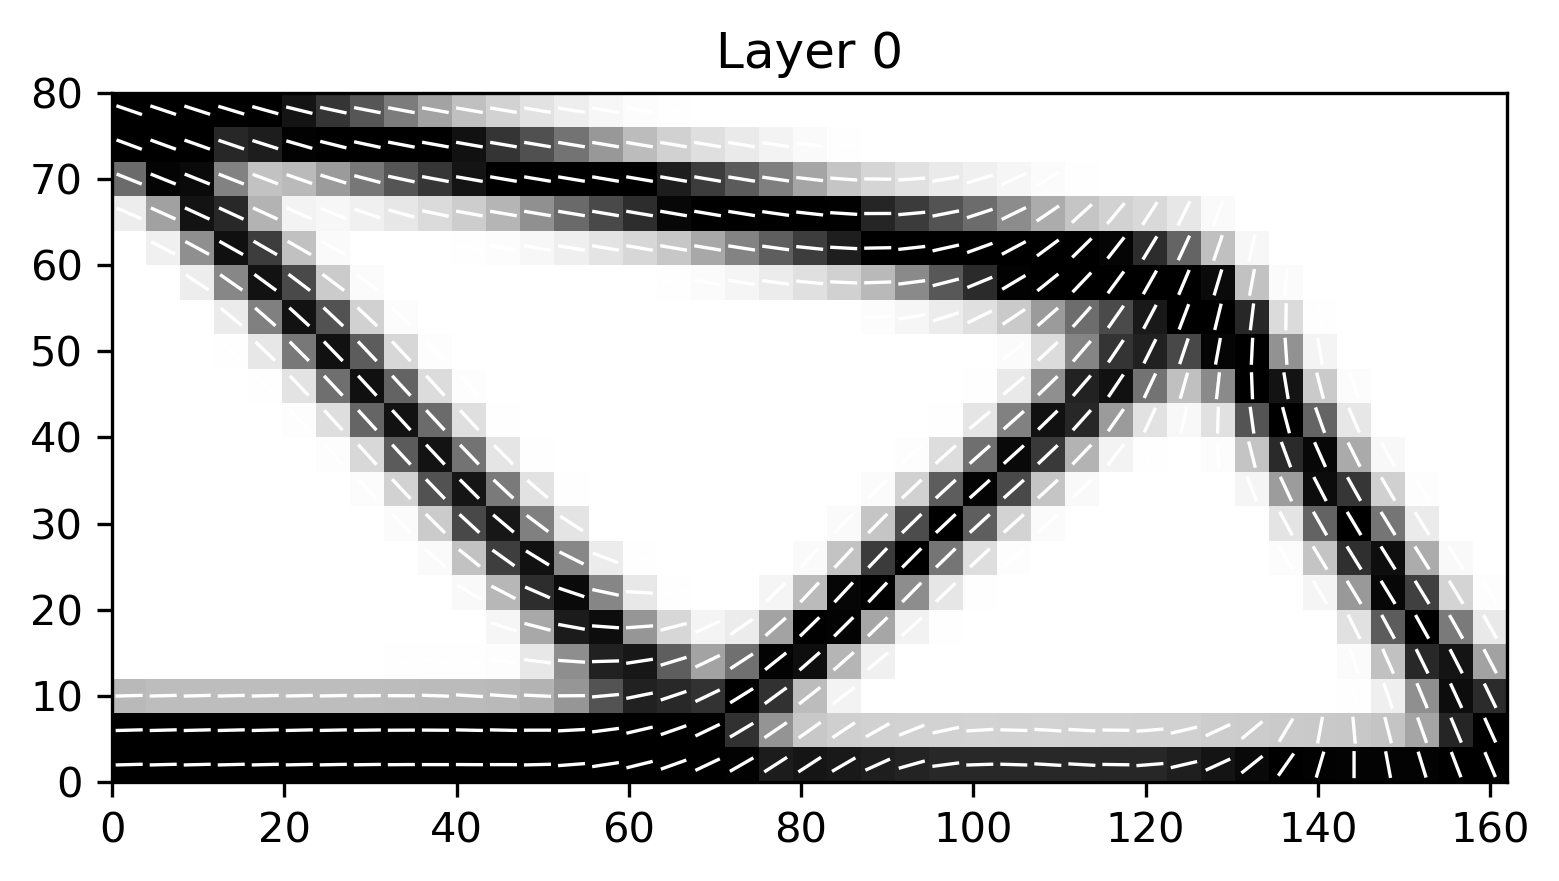

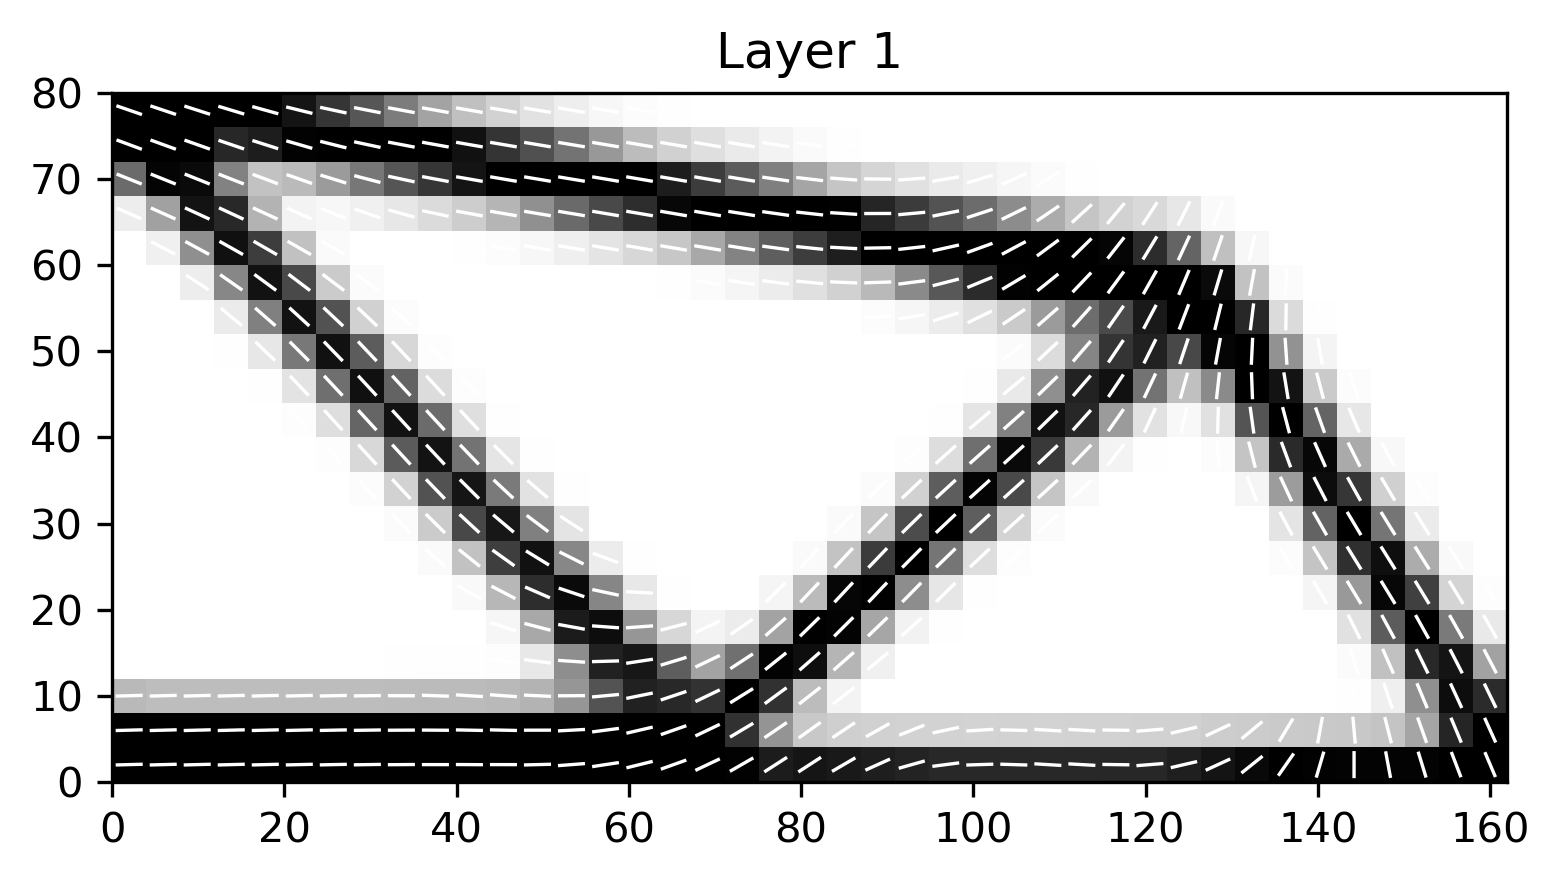

In [7]:
post2 = Post3D(solver2)
post2.plot_convergence()
post2.plot()
post2.plot_layer(layer=0)
post2.plot_layer(layer=1)

print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post2.CO2_footprint(rho, CO2mat, CO2veh)))